# DDPM paper reimplementation
This notebook is a reimplementation of the Denoising Diffusion Probabilistic Models paper. Moreover it allows to test multiple variations such as using cosine Beta schedule, different learning rates, different datasets and other modifications. 

Both Conditional and Unconditional U-Net are tested in this implementation.
## Utils functions
These two functions are used to find which device to use and to modify the input dataset resizing the data and normalizing the tensors. Moreover it splits the dataset into training, validation and test.

In [16]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import random_split

def get_device(torch):
    """
    Determines the device to be used for PyTorch operations.

    If the environment variable 'FORCE_DEVICE' is set, it returns its value.
    Otherwise, it checks for available devices in the following order:
    - CUDA (GPU)
    - MPS (Apple's Metal Performance Shaders)
    - CPU

    Args:
        torch (module): The PyTorch module.

    Returns:
        torch.device: The device to be used for PyTorch operations.
    """
    if "FORCE_DEVICE" in os.environ:
        return os.environ["FORCE_DEVICE"]

    return torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu"))

def get_dataset(dataset_name):
    """
    Downloads and prepares a specified dataset (MNIST, CIFAR10, or Fashion-MNIST).

    Applies a series of transformations to the images:
    - Resize to 32x32 pixels.
    - Convert to a tensor.
    - Normalize the tensor values to the range [-1, 1].

    Splits the training data into training and validation sets (90% training, 10% validation).

    Args:
        dataset_name (str): The name of the dataset to download and prepare. 
                            Supported values are 'MNIST', 'CIFAR10', and 'Fashion-MNIST'.

    Returns:
        tuple: A tuple containing the training dataset, validation dataset, and test dataset.

    Raises:
        ValueError: If an unsupported dataset name is provided.
    """
    image_size = 32
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),       # Resizes the image based on dataset
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ])
    if dataset_name == "MNIST":
        train_data = datasets.MNIST(root="data", train=True, transform=transform, download=True)
        train_size = int(0.9 * len(train_data))
        val_size = len(train_data) - train_size
        train_dataset, val_dataset = random_split(train_data, [train_size, val_size])
        test_dataset = datasets.MNIST(root="data", train=False, transform=transform, download=True)
    elif dataset_name == "CIFAR10":
        train_data = datasets.CIFAR10(root="data", train=True, transform=transform, download=True)
        train_size = int(0.9 * len(train_data))
        val_size = len(train_data) - train_size
        train_dataset, val_dataset = random_split(train_data, [train_size, val_size])
        test_dataset = datasets.CIFAR10(root="data", train=False, transform=transform, download=True)
    elif dataset_name == "Fashion-MNIST":
        train_data = datasets.FashionMNIST(root="data", train=True, transform=transform, download=True)
        train_size = int(0.9 * len(train_data))
        val_size = len(train_data) - train_size
        train_dataset, val_dataset = random_split(train_data, [train_size, val_size])
        test_dataset = datasets.FashionMNIST(root="data", train=False, transform=transform, download=True)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    return train_dataset, val_dataset, test_dataset


## Beta schedule
In this section the functions used to compute the beta schedule values $\beta_t$, $\alpha_t$ and $\bar \alpha_t$.

In [17]:
import torch.nn as nn
import torch.nn.functional as F
!pip install lightning
import lightning as L
!pip install transformers
from transformers import get_cosine_schedule_with_warmup
from torchvision.transforms import RandomHorizontalFlip
import logging
def linear_beta_schedule(min_beta: float = 1e-4, max_beta: float = 0.02, timesteps: int = 1000) -> torch.Tensor:
    """
    Function that returns the beta values at every step
    for the given range [min_beta, max_beta] and T

    Args:
        min_beta (float): Minimum beta value
        max_beta (float): Maximum beta value
        T (int): Number of steps

    Returns:
        torch.Tensor: Beta values for each step
    """
    return torch.cat((torch.tensor([0.0]), torch.linspace(min_beta, max_beta, timesteps, dtype=torch.float32)))

def cosine_beta_schedule(timesteps: int = 1000, s: float = 0.008) -> torch.Tensor:
    timesteps = torch.linspace(0, timesteps, timesteps + 1, dtype=t.float32)
    alphas_bar = torch.cos((timesteps / timesteps + s) / (1 + s) * torch.pi / 2) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]  # Normalize alphas_bar to start at 1
    betas = 1.0 - alphas_bar[1:] / alphas_bar[:-1]
    betas = torch.clamp(betas, max=0.999)  # Ensure max beta is 0.999
    return torch.cat((t.tensor([0.0]), betas))

def sigmoid_beta_schedule(min_beta: float = 1e-4, max_beta: float = 0.02, T: int = 1000, s: float = 0.008) -> torch.Tensor:
    """
    Function that returns the beta values for a sigmoid schedule.

    Args:
        min_beta (float): Minimum beta value.
        max_beta (float): Maximum beta value.
        T (int): Number of steps.
        s (float): Scale factor to adjust the sharpness of the sigmoid curve.

    Returns:
        torch.Tensor: Beta values for each step.
    """
    # Define the sigmoid function according to the schedule
    def sigmoid_fn(timestep):
        return min_beta + (max_beta - min_beta) / (1 + torch.exp(-s * (timestep - T // 2)))

    betas = [sigmoid_fn(timestep) for timestep in range(T)]

    return torch.cat((t.tensor([0.0]), torch.tensor(betas, dtype=t.float32)))


def compute_alphas(betas: torch.Tensor) -> torch.Tensor:
    """
    Compute alpha values from beta values

    Args:
        betas (t.Tensor): Beta values

    Returns:
        torch.Tensor: Alpha values
    """
    return 1 - betas

def compute_alphas_hat(betas: torch.Tensor) -> torch.Tensor:
    """
    Compute cumulative product of alpha values from beta values

    Args:
        betas (t.Tensor): Beta values

    Returns:
        torch.Tensor: Cumulative product of alpha values
    """
    alphas = 1 - betas
    alphas_hat = torch.cumprod(alphas, dim=0)
    return alphas_hat


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


## Conditional U-Net
In this part the conditional U-Net is defined. The keypoints are the use of Attention modules and the use of Sinusoidal positional embeddings for the timestamp. Moreover, the use of the class embedding.

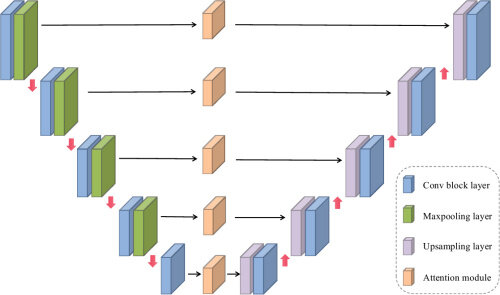

In [18]:
import torch.nn as nn
import torch.nn.functional as F

import logging

logger = logging.getLogger(__name__)


def space_to_depth(x, size=2):
  """
  Downsacle method that use the depth dimension to
  downscale the spatial dimensions
  Args:
      x (torch.Tensor): a tensor to downscale
      size (float): the scaling factor

  Returns:
      (torch.Tensor): new spatial downscale tensor
  """
  b, c, h, w = x.shape
  out_h = h // size
  out_w = w // size
  out_c = c * (size * size)
  x = x.reshape((-1, c, out_h, size, out_w, size))
  x = x.permute((0, 1, 3, 5, 2, 4))
  x = x.reshape((-1, out_c, out_h, out_w))
  return x


class SpaceToDepth(nn.Module):
  def __init__(self, size):
    super().__init__()
    self.size = size

  def forward(self, x):
    return space_to_depth(x, self.size)


class Residual(nn.Module):
  """
  Apply residual connection using an input function
  Args:
    func (function): a function to apply over the input
  """

  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x, *args, **kwargs):
    return x + self.func(x, *args, **kwargs)


def upsample(in_channels, out_channels=None):
  out_channels = in_channels if out_channels is None else out_channels
  seq = nn.Sequential(
      nn.Upsample(scale_factor=2, mode='nearest'),
      nn.Conv2d(in_channels, out_channels, 3, padding=1)
  )
  return seq


def downsample(in_channels, out_channels=None):
  out_channels = in_channels if out_channels is None else out_channels
  seq = nn.Sequential(
      SpaceToDepth(2),
      nn.Conv2d(4 * in_channels, out_channels, 1)
  )
  return seq


class SinusodialPositionEmbedding(nn.Module):
  def __init__(self, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim

  def forward(self, time_steps):
    positions = torch.unsqueeze(time_steps, 1)
    half_dim = self.embedding_dim // 2
    embeddings = torch.zeros(
        (time_steps.shape[0], self.embedding_dim), device=time_steps.device)
    denominators = 10_000 ** (2 * torch.arange(self.embedding_dim //
                              2, device=time_steps.device) / self.embedding_dim)
    embeddings[:, 0::2] = torch.sin(positions/denominators)
    embeddings[:, 1::2] = torch.cos(positions/denominators)
    return embeddings


class WeightStandardizedConv2d(nn.Conv2d):
  """
  https://arxiv.org/abs/1903.10520
  weight standardization purportedly works synergistically with group normalization
  """

  def forward(self, x):
    eps = 1e-5 if x.dtype == torch.float32 else 1e-3

    weight = self.weight
    mean = weight.mean(dim=[1, 2, 3], keepdim=True)
    variance = weight.var(dim=[1, 2, 3], keepdim=True, correction=0)
    normalized_weight = (weight - mean) / torch.sqrt(variance)

    return F.conv2d(
        x,
        normalized_weight,
        self.bias,
        self.stride,
        self.padding,
        self.dilation,
        self.groups
    )


class Block(nn.Module):
  def __init__(self, in_channels, out_channels, groups=8):
    super().__init__()
    self.proj = WeightStandardizedConv2d(
        in_channels, out_channels, 3, padding=1)
    self.norm = nn.GroupNorm(groups, out_channels)
    self.act = nn.SiLU()

  def forward(self, x, scale_shift=None):
    x = self.proj(x)
    x = self.norm(x)

    if scale_shift is not None:
      scale, shift = scale_shift
      x = x * (scale + 1) + shift

    x = self.act(x)
    return x


class ResnetBlockConditional(nn.Module):
  def __init__(self, in_channels, out_channels, time_emb_dim=None, class_emb_dim=None, groups=8):
    super().__init__()
    # MLP for time embeddings
    if time_emb_dim is not None:
      self.time_mlp = nn.Sequential(
          nn.SiLU(),
          nn.Linear(time_emb_dim, 2 * out_channels)
      )
    else:
      self.time_mlp = None

    # MLP for class embeddings
    if class_emb_dim is not None:
      self.class_mlp = nn.Sequential(
          nn.SiLU(),
          nn.Linear(class_emb_dim, 2 * out_channels)
      )
    else:
      self.class_mlp = None

    # ResNet blocks
    self.block1 = Block(in_channels, out_channels, groups)
    self.block2 = Block(out_channels, out_channels, groups)

    # Residual connection
    if in_channels == out_channels:
      self.res_conv = nn.Identity()
    else:
      self.res_conv = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self, x, time_emb=None, class_emb=None):
    scale_shift = None

    # Process time embedding
    if self.time_mlp is not None and time_emb is not None:
      time_emb = self.time_mlp(time_emb)
      time_emb = time_emb.view(*time_emb.shape, 1, 1)
      scale_shift = time_emb.chunk(2, dim=1)

    # Process class embedding
    if self.class_mlp is not None and class_emb is not None:
      class_emb = self.class_mlp(class_emb)
      class_emb = class_emb.view(*class_emb.shape, 1, 1)
      class_scale_shift = class_emb.chunk(2, dim=1)

      # Combine scale and shift from time and class embeddings
      if scale_shift is None:
        scale_shift = class_scale_shift
      else:
        scale_shift = (
            scale_shift[0] + class_scale_shift[0],
            scale_shift[1] + class_scale_shift[1]
        )

    # Forward pass through blocks
    h = self.block1(x, scale_shift=scale_shift)
    h = self.block2(h)
    return h + self.res_conv(x)


class Attention(nn.Module):
  def __init__(self, in_channels, num_heads=4, dim_head=32):
    super().__init__()
    self.num_heads = num_heads
    self.dim_head = dim_head
    self.scale_factor = 1 / (dim_head) ** 0.5
    self.hidden_dim = num_heads * dim_head
    self.input_to_qkv = nn.Conv2d(
        in_channels, 3 * self.hidden_dim, 1, bias=False)
    self.to_output = nn.Conv2d(self.hidden_dim, in_channels, 1)

  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.input_to_qkv(x)
    q, k, v = map(lambda t: t.view(b, self.num_heads,
                  self.dim_head, h * w), qkv.chunk(3, dim=1))
    q = q * self.scale_factor
    # dot product between the columns of q and k
    sim = torch.einsum("b h c i, b h c j -> b h i j", q, k)
    sim = sim - sim.amax(dim=-1, keepdim=True).detach()
    attention = sim.softmax(dim=-1)

    # dot product between the rows to get the wighted values as columns
    output = torch.einsum("b h i j, b h c j -> b h i c", attention, v)
    output = output.permute(0, 1, 3, 2).reshape((b, self.hidden_dim, h, w))
    return self.to_output(output)


class LinearAttention(nn.Module):
  def __init__(self, in_channels, num_heads=4, dim_head=32):
    super().__init__()
    self.num_heads = num_heads
    self.dim_head = dim_head
    self.scale_factor = 1 / (dim_head) ** 0.5
    self.hidden_dim = num_heads * dim_head
    self.input_to_qkv = nn.Conv2d(
        in_channels, 3 * self.hidden_dim, 1, bias=False)
    self.to_output = nn.Sequential(
        nn.Conv2d(self.hidden_dim, in_channels, 1),
        nn.GroupNorm(1, in_channels)
    )

  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.input_to_qkv(x)
    q, k, v = map(lambda t: t.view(b, self.num_heads,
                  self.dim_head, h * w), qkv.chunk(3, dim=1))

    q = q.softmax(dim=-2)
    k = k.softmax(dim=-1)

    q = q * self.scale_factor
    context = torch.einsum("b h d n, b h e n -> b h d e", k, v)
    output = torch.einsum("b h d e, b h d n -> b h e n", context, q)
    output = output.view((b, self.hidden_dim, h, w))
    return self.to_output(output)


class PreGroupNorm(nn.Module):
  def __init__(self, dim, func, groups=1):
    super().__init__()
    self.func = func
    self.group_norm = nn.GroupNorm(groups, dim)

  def forward(self, x):
    x = self.group_norm(x)
    x = self.func(x)
    return x


class DiffusionConditionalUnet(nn.Module):
  def __init__(self, dim, init_dim=None, output_dim=None, dim_mults=(1, 2, 4, 8), channels=3, resnet_block_groups=4, cond=False):
    super().__init__()

    self.channels = channels
    init_dim = init_dim if init_dim is not None else dim
    self.init_conv = nn.Conv2d(self.channels, init_dim, 1)
    dims = [init_dim] + [m * dim for m in dim_mults]
    input_output_dims = list(zip(dims[:-1], dims[1:]))

    time_dim = 4 * dim  # time embedding

    self.time_mlp = nn.Sequential(
        SinusodialPositionEmbedding(dim),
        nn.Linear(dim, time_dim),
        nn.GELU(),
        nn.Linear(time_dim, time_dim)
    )

    # TODO this encoding makes no sense, fix it
    self.class_mlp = nn.Sequential(
        # module to log dimension
        SinusodialPositionEmbedding(dim),
        nn.Linear(dim, time_dim),
        nn.GELU(),
        nn.Linear(time_dim, time_dim)
    )

    # down layers
    self.down_layers = nn.ModuleList([])
    for ii, (dim_in, dim_out) in enumerate(input_output_dims, 1):
      is_last = ii == len(input_output_dims)
      self.down_layers.append(
          nn.ModuleList(
              [
                  ResnetBlockConditional(dim_in, dim_in, time_emb_dim=time_dim,
                              class_emb_dim=(time_dim if cond else None),
                              groups=resnet_block_groups),
                  ResnetBlockConditional(dim_in, dim_in, time_emb_dim=time_dim,
                              class_emb_dim=(time_dim if cond else None),
                              groups=resnet_block_groups),
                  Residual(PreGroupNorm(
                      dim_in, LinearAttention(dim_in))),
                  downsample(dim_in, dim_out) if not is_last else nn.Conv2d(
                      dim_in, dim_out, 3, padding=1)
              ]
          )
      )

      # middle layers
      mid_dim = dims[-1]
      self.mid_block1 = ResnetBlockConditional(
          mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
      self.mid_attention = Residual(
          PreGroupNorm(mid_dim, Attention(mid_dim)))
      self.mid_block2 = ResnetBlockConditional(
          mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

      # up layers
      self.up_layers = nn.ModuleList([])
      for ii, (dim_in, dim_out) in enumerate(reversed(input_output_dims), 1):
        is_last = ii == len(input_output_dims)
        self.up_layers.append(
            nn.ModuleList(
                [
                    ResnetBlockConditional(
                        dim_out + dim_in, dim_out, time_emb_dim=time_dim,
                        class_emb_dim=(time_dim if cond else None),
                        groups=resnet_block_groups),
                    ResnetBlockConditional(
                        dim_out + dim_in, dim_out, time_emb_dim=time_dim,
                        class_emb_dim=(time_dim if cond else None),
                        groups=resnet_block_groups),
                    Residual(PreGroupNorm(
                        dim_out, LinearAttention(dim_out))),
                    upsample(dim_out, dim_in) if not is_last else nn.Conv2d(
                        dim_out, dim_in, 3, padding=1)
                ]
            )
        )

        self.output_dim = output_dim if output_dim is not None else channels
        self.final_res_block = ResnetBlockConditional(
            2 * dim, dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.final_conv = nn.Conv2d(dim, self.output_dim, 1)

  def forward(self, x, time, klass):
    x = self.init_conv(x)
    init_result = x.clone()

    t = self.time_mlp(time)
    c = self.class_mlp(klass)

    h = []

    for block1, block2, attention, downsample_block in self.down_layers:
      x = block1(x, t, c)
      h.append(x)

      x = block2(x, t, c)
      x = attention(x)

      h.append(x)

      x = downsample_block(x)

    x = self.mid_block1(x, t)
    x = self.mid_attention(x)
    x = self.mid_block2(x, t)

    for block1, block2, attention, upsample_block in self.up_layers:
      x = torch.cat((x, h.pop()), dim=1)
      x = block1(x, t, c)

      x = torch.cat((x, h.pop()), dim=1)
      x = block2(x, t, c)

      x = attention(x)

      x = upsample_block(x)

    x = torch.cat((x, init_result), dim=1)
    x = self.final_res_block(x, t)
    x = self.final_conv(x)
    return x


## Unconditional U-Net
U-Net analogous to one defined above, but without the conditioning which allows to decide which class to output.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def space_to_depth(x, size=2):
    """
    Downsacle method that use the depth dimension to
    downscale the spatial dimensions
    Args:
        x (torch.Tensor): a tensor to downscale
        size (float): the scaling factor

    Returns:
        (torch.Tensor): new spatial downscale tensor
    """
    b, c, h, w = x.shape
    out_h = h // size
    out_w = w // size
    out_c = c * (size * size)
    x = x.reshape((-1, c, out_h, size, out_w, size))
    x = x.permute((0, 1, 3, 5, 2, 4))
    x = x.reshape((-1, out_c, out_h, out_w))
    return x


class SpaceToDepth(nn.Module):
  def __init__(self, size):
    super().__init__()
    self.size = size

  def forward(self, x):
    return space_to_depth(x, self.size)


class Residual(nn.Module):
  """
  Apply residual connection using an input function
  Args:
    func (function): a function to apply over the input
  """
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x, *args, **kwargs):
    return x + self.func(x, *args, **kwargs)

def upsample(in_channels, out_channels=None):
  out_channels = in_channels if out_channels is None else out_channels
  seq = nn.Sequential(
      nn.Upsample(scale_factor=2, mode='nearest'),
      nn.Conv2d(in_channels, out_channels, 3, padding=1)
  )
  return seq

def downsample(in_channels, out_channels=None):
  out_channels = in_channels if out_channels is None else out_channels
  seq = nn.Sequential(
      SpaceToDepth(2),
      nn.Conv2d(4 * in_channels, out_channels, 1)
  )
  return seq

class SinusodialPositionEmbedding(nn.Module):
  def __init__(self, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim

  def forward(self, time_steps):
    positions = torch.unsqueeze(time_steps, 1)
    half_dim = self.embedding_dim // 2
    embeddings = torch.zeros((time_steps.shape[0], self.embedding_dim), device=time_steps.device)
    denominators = 10_000 ** (2 * torch.arange(self.embedding_dim // 2, device=time_steps.device) / self.embedding_dim)
    embeddings[:, 0::2] = torch.sin(positions/denominators)
    embeddings[:, 1::2] = torch.cos(positions/denominators)
    return embeddings

class WeightStandardizedConv2d(nn.Conv2d):
  """
  https://arxiv.org/abs/1903.10520
  weight standardization purportedly works synergistically with group normalization
  """

  def forward(self, x):
    eps = 1e-5 if x.dtype == torch.float32 else 1e-3

    weight = self.weight
    mean = weight.mean(dim=[1,2,3], keepdim=True)
    variance = weight.var(dim=[1,2,3], keepdim=True, correction=0)
    normalized_weight = (weight - mean) / torch.sqrt(variance)

    return F.conv2d(
        x,
        normalized_weight,
        self.bias,
        self.stride,
        self.padding,
        self.dilation,
        self.groups
    )


class Block(nn.Module):
  def __init__(self, in_channels, out_channels, groups=8, dropout=0.0):
    super().__init__()
    self.proj = WeightStandardizedConv2d(in_channels, out_channels, 3, padding=1)
    self.norm = nn.GroupNorm(groups, out_channels)
    self.act = nn.SiLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, scale_shift=None):
    x = self.proj(x)
    x = self.norm(x)

    if scale_shift is not None:
      scale, shift = scale_shift
      x = x * (scale + 1) + shift

    x = self.act(x)
    return self.dropout(x)

class ResnetBlockUnconditional(nn.Module):
  def __init__(self, in_channels, out_channels, time_emb_dim=None, groups=8, dropout=0.0):
    super().__init__()
    if time_emb_dim is not None:
      self.mlp = nn.Sequential(
          nn.SiLU(),
          nn.Linear(time_emb_dim, 2 * out_channels)
      )
    else:
      self.mlp = None

    self.block1 = Block(in_channels, out_channels, groups, dropout)
    self.block2 = Block(out_channels, out_channels, groups, dropout)
    if in_channels == out_channels:
      self.res_conv = nn.Identity()
    else:
      self.res_conv = nn.Conv2d(in_channels, out_channels, 1)

  def forward(self, x, time_emb=None):
    scale_shift = None
    if self.mlp is not None and time_emb is not None:
      time_emb = self.mlp(time_emb)
      time_emb = time_emb.view(*time_emb.shape, 1, 1)
      scale_shift = time_emb.chunk(2, dim=1) ########

    h = self.block1(x, scale_shift=scale_shift)
    h = self.block2(h)
    return h + self.res_conv(x)

class Attention(nn.Module):
  def __init__(self, in_channels, num_heads=4, dim_head=32):
    super().__init__()
    self.num_heads = num_heads
    self.dim_head = dim_head
    self.scale_factor = 1 / (dim_head) ** 0.5
    self.hidden_dim = num_heads * dim_head
    self.input_to_qkv = nn.Conv2d(in_channels, 3 * self.hidden_dim, 1, bias=False)
    self.to_output = nn.Conv2d(self.hidden_dim, in_channels, 1)

  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.input_to_qkv(x)
    q, k, v = map(lambda t: t.view(b, self.num_heads, self.dim_head, h * w), qkv.chunk(3, dim=1))
    q = q * self.scale_factor
    # dot product between the columns of q and k
    sim = torch.einsum("b h c i, b h c j -> b h i j", q, k)
    sim = sim - sim.amax(dim=-1, keepdim=True).detach()
    attention = sim.softmax(dim=-1)

    # dot product between the rows to get the wighted values as columns
    output = torch.einsum("b h i j, b h c j -> b h i c", attention, v)
    output = output.permute(0, 1, 3, 2).reshape((b, self.hidden_dim, h, w))
    return self.to_output(output)


class LinearAttention(nn.Module):
  def __init__(self, in_channels, num_heads=4, dim_head=32):
    super().__init__()
    self.num_heads = num_heads
    self.dim_head = dim_head
    self.scale_factor = 1 / (dim_head) ** 0.5
    self.hidden_dim = num_heads * dim_head
    self.input_to_qkv = nn.Conv2d(in_channels, 3 * self.hidden_dim, 1, bias=False)
    self.to_output = nn.Sequential(
        nn.Conv2d(self.hidden_dim, in_channels, 1),
        nn.GroupNorm(1, in_channels)
    )

  def forward(self, x):
    b, c, h, w = x.shape
    qkv = self.input_to_qkv(x)
    q, k, v = map(lambda t: t.view(b, self.num_heads, self.dim_head, h * w), qkv.chunk(3, dim=1))

    q = q.softmax(dim=-2)
    k = k.softmax(dim=-1)

    q = q * self.scale_factor
    context = torch.einsum("b h d n, b h e n -> b h d e", k, v)
    output = torch.einsum("b h d e, b h d n -> b h e n", context, q)
    output = output.view((b, self.hidden_dim, h, w))
    return self.to_output(output)

class PreGroupNorm(nn.Module):
  def __init__(self, dim , func, groups=1):
    super().__init__()
    self.func = func
    self.group_norm = nn.GroupNorm(groups, dim)

  def forward(self, x):
    x = self.group_norm(x)
    x = self.func(x)
    return x

class DiffusionUnconditionalUnet(nn.Module):
  def __init__(self, dim, init_dim=None, output_dim=None, dim_mults=(1, 2, 4, 8), channels=3, resnet_block_groups=4, dropout=0.0, dim_att_head=32):
    super().__init__()

    self.channels = channels
    init_dim = init_dim if init_dim is not None else dim
    self.init_conv = nn.Conv2d(self.channels, init_dim, 1)
    dims = [init_dim] + [m * dim for m in dim_mults]
    input_output_dims = list(zip(dims[:-1], dims[1:]))

    time_dim = 4 * dim  # time embedding

    self.time_mlp = nn.Sequential(
        SinusodialPositionEmbedding(dim),
        nn.Linear(dim, time_dim),
        nn.GELU(),
        nn.Linear(time_dim, time_dim)
    )

    # down layers
    self.down_layers = nn.ModuleList([])
    for ii, (dim_in, dim_out) in enumerate(input_output_dims, 1):
      is_last = ii == len(input_output_dims)
      self.down_layers.append(
          nn.ModuleList(
              [
                  ResnetBlockUnconditional(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups, dropout=dropout),
                  ResnetBlockUnconditional(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups, dropout=dropout),
                  Residual(PreGroupNorm(dim_in, LinearAttention(dim_in, dim_head=dim_att_head))),
                  downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
              ]
          )
      )

      # middle layers
      mid_dim = dims[-1]
      self.mid_block1 = ResnetBlockUnconditional(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups, dropout=dropout)
      self.mid_attention = Residual(PreGroupNorm(mid_dim, Attention(mid_dim, dim_head=dim_att_head)))
      self.mid_block2 = ResnetBlockUnconditional(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups, dropout=dropout)

      # up layers
      self.up_layers = nn.ModuleList([])
      for ii, (dim_in, dim_out) in enumerate(reversed(input_output_dims), 1):
        is_last = ii == len(input_output_dims)
        self.up_layers.append(
            nn.ModuleList(
                [
                    ResnetBlockUnconditional(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups, dropout=dropout),
                    ResnetBlockUnconditional(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups, dropout=dropout),
                    Residual(PreGroupNorm(dim_out, LinearAttention(dim_out, dim_head=dim_att_head))),
                    upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                ]
            )
        )

        self.output_dim = output_dim if output_dim is not None else channels
        self.final_res_block = ResnetBlockUnconditional(2 * dim, dim, time_emb_dim=time_dim, groups=resnet_block_groups, dropout=dropout)
        self.final_conv = nn.Conv2d(dim, self.output_dim, 1)

  def forward(self, x, time):
    x = self.init_conv(x)
    init_result = x.clone()
    t = self.time_mlp(time)
    h = []

    for block1, block2, attention, downsample_block in self.down_layers:
      x = block1(x, t)
      h.append(x)

      x = block2(x, t)
      x = attention(x)

      h.append(x)

      x = downsample_block(x)

    x = self.mid_block1(x, t)
    x = self.mid_attention(x)
    x = self.mid_block2(x ,t)

    for block1, block2, attention, upsample_block in self.up_layers:
      x = torch.cat((x , h.pop()), dim=1)
      x = block1(x, t)

      x = torch.cat((x, h.pop()), dim=1)
      x = block2(x, t)

      x = attention(x)

      x = upsample_block(x)

    x = torch.cat((x, init_result), dim=1)
    x = self.final_res_block(x, t)
    x = self.final_conv(x)
    return x

## DDPM sampling and training
This section introduces logging, adding Gaussian noise to images, and includes classes for implementing and training a denoising diffusion probabilistic model (DDPM) such as methods for sampling, training, and validation within the DDPM framework.

In [20]:
logger = logging.getLogger(__name__)

T = 1000
timesteps = 1000
device = get_device(torch)

logger.info(f"Using device: {device}")

def add_noise(x_0, alpha_hat_t):
    """
    Add Gaussian noise to an image tensor,
    given alpha as the noise level using PyTorch.
    """

    # Reshape alpha_hat_t to match the dimensions of x_0 for broadcasting
    alpha_hat_t = alpha_hat_t.view(-1, 1, 1, 1)

    gaussian_noise = torch.randn_like(x_0)

    # Generate Gaussian noise with the same shape as x_0
    noise = gaussian_noise * torch.sqrt(1 - alpha_hat_t)
    mean = x_0 * torch.sqrt(alpha_hat_t)

    # Return the image tensor with added noise
    return (noise + mean), gaussian_noise


def sample_tS(T, size):
    """
    Sample a tensor of shape size with values from [1, T] inclusive
    """

    return torch.randint(1, timesteps+1, size=size)


class DdpmNet(nn.Module):
    def __init__(self, unet_dim, channels, img_size, beta_schedule, loss_type="smooth_l1_loss", lr=3e-4, cond=False, dim_mults=(1,2,4,8), resnet_block_groups=4, dropout=0.0, horizontal_flips=False, dim_att_head=32):
        super().__init__()
        self.channels = channels
        self.img_size = img_size
        self.cond = cond
        if cond:
            self.unet = DiffusionConditionalUnet(dim=unet_dim, channels=channels, cond=cond)
        else:
            self.unet = DiffusionUnconditionalUnet(dim=unet_dim, channels=channels, dim_mults=dim_mults, resnet_block_groups=resnet_block_groups, dim_att_head=dim_att_head)
        self.beta_schedule = beta_schedule
        if beta_schedule == "linear":
            self.betas = linear_beta_schedule(1e-4, 0.02, timesteps).to(device)
        elif beta_schedule == "cosine":
            self.betas = cosine_beta_schedule(T, s=0.008).to(device)
        elif beta_schedule == "sigmoid":
            self.betas = sigmoid_beta_schedule(T=T).to(device)
        self.loss_type = loss_type
        self.lr = lr
        self.horizontal_flips = horizontal_flips

        self.alphas_hat = compute_alphas_hat(self.betas)
        self.alphas = compute_alphas(self.betas)

    def forward(self, x, t, c):
        if self.cond:
            return self.unet(x, t, c)
        else:
            return self.unet(x, t)


class DdpmLight(L.LightningModule):
    def __init__(self, ddpmnet, use_scheduler=False, len_train_set=0, epochs=0):
        super().__init__()
        self.ddpmnet = ddpmnet
        self.use_scheduler = use_scheduler
        self.len_train_set = len_train_set
        self.epochs = epochs
        self.rand_horizontal_flip = RandomHorizontalFlip(p=0.5)


    def sample(self, count, klass):
        x = torch.randn(count, self.ddpmnet.channels, self.ddpmnet.img_size, self.ddpmnet.img_size).to(self.device)  # Use torch.randn for consistency
        for int_i in reversed(range(T)):
            x = self.forward_sample(x, int_i + 1, klass)
            # logger.info(f"Sampled timestep {int_i + 1}")
        return x

    def forward_sample(self, x, int_i, klass):
        bs = x.size(0)
        i = torch.full((bs,), int_i, device=self.device, dtype=torch.long)

        if not isinstance(klass, torch.Tensor):
            klass = torch.full((bs,), klass).to(self.device)

        # Extract parameters
        alpha_t = self.ddpmnet.alphas[i].view(bs, 1, 1, 1)
        alpha_hat_t = self.ddpmnet.alphas_hat[i].view(bs, 1, 1, 1)
        beta_t = self.ddpmnet.betas[i].view(bs, 1, 1, 1)

        # Predict noise
        pred = self.ddpmnet(x, i, klass)


        # Compute model mean
        model_mean = (1 / alpha_t.sqrt()) * (
            x - ((1 - alpha_t) / (1 - alpha_hat_t).sqrt()) * pred
        )
        # Sample the next step
        if int_i > 1:
            model_mean += torch.randn_like(x) * beta_t.sqrt()

        return model_mean

    def step(self, batch, _):
        x, y = batch

        x = x.to(self.device)

        if self.ddpmnet.horizontal_flips:
            x = self.rand_horizontal_flip(x)

        bs = x.size(0)

        ts = sample_tS(T, size=(bs,)).to(self.device) # Timestep for each sample

        cs = y.to(self.device) # Label for each sample

        alpha_hat = self.ddpmnet.alphas_hat[ts]

        noised_x, gaussian_noise = add_noise(x, alpha_hat)

        prediction = self.ddpmnet(noised_x, ts, cs)

        if self.ddpmnet.loss_type == "smooth_l1":
            return F.smooth_l1_loss(gaussian_noise, prediction)
        elif self.ddpmnet.loss_type == "mse":
            return F.mse_loss(gaussian_noise, prediction)
        else:
            raise ValueError("Invalid loss type")

    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.ddpmnet.lr)

        if self.use_scheduler:
            # Create the learning rate scheduler
            lr_scheduler = get_cosine_schedule_with_warmup(
                optimizer=optimizer,
                num_warmup_steps=100,  # Set to the number of steps for warmup if desired
                num_training_steps=(self.len_train_set * self.epochs),
            )
            # Return both the optimizer and the scheduler
            return [optimizer], [lr_scheduler]
        else:
            return optimizer

    def on_train_epoch_end(self):
        # Optionally log learning rate at the end of each epoch
        lr = self.optimizers().param_groups[0]['lr']
        logger.info(f"Learning rate at epoch end: {lr}")


1253066481.py: INFO: <module>(): 7:	Using device: cuda


## Training
Here training of the network is performed using Pytorch Lightning, which allows to reduce the boilerplate code. 

In [21]:
import argparse
from lightning.pytorch.callbacks import ModelCheckpoint
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import lightning as L
import logging
import os

logging.basicConfig(
    level=logging.INFO,
    format=('%(filename)s: '
            '%(levelname)s: '
            '%(funcName)s(): '
            '%(lineno)d:\t'
            '%(message)s')
)

logger = logging.getLogger(__name__)

def main():
    dataset_name = "MNIST"
    unet_dim = 32
    beta_schedule = "linear"
    loss_type = "smooth_l1"
    lr = 3e-4
    cond = False
    epochs = 1
    use_scheduler = False
    batch_size = 32

    logger.info(f"Using dataset: {dataset_name}")
    logger.info(f"Using U-Net dimension: {unet_dim}")
    logger.info(f"Using beta schedule: {beta_schedule}")
    logger.info(f"Using loss type: {loss_type}")
    logger.info(f"Using learning rate: {lr}")
    logger.info(f"Using conditional unet: {cond}")
    logger.info(f"Using batch size: {batch_size}")
    logger.info(f"Using scheduler: {use_scheduler}")

    # Set device to cuda if available, set to mps if available else cpu
    device = get_device(torch)
    logger.info(f"Using device: {device}")

    train_dataset, val_dataset, test_dataset = get_dataset(dataset_name)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Pass the U-Net dimension, beta scheduler, loss type, and learning rate to the DdpmNet constructor
    num_channels = 3 if dataset_name == 'CIFAR10' else 1
    image_size = 32

    if dataset_name == "CIFAR10":
        # Using the same settings of the original paper
        dim_mults = (1,2,2,2)
        resnet_block_groups = 2
        dropout = 0.1
        horizontal_flips = True
        dim_att_head = 16
    else:
        dim_mults = (1,2,4,8)
        resnet_block_groups = 4
        dropout = 0.0
        horizontal_flips = False
        dim_att_head = 32

    logger.info(f"Using dim mults: {dim_mults}")
    logger.info(f"Using resnet block groups: {resnet_block_groups}")
    logger.info(f"Using dropout: {dropout}")
    logger.info(f"Using horizontal flips: {horizontal_flips}")
    logger.info(f"Using dim att head: {dim_att_head}")

    model = DdpmNet(unet_dim=unet_dim,
                    channels=num_channels,
                    img_size=image_size,
                    beta_schedule=beta_schedule,
                    loss_type=loss_type,
                    lr=lr,
                    cond=cond,
                    dim_mults=dim_mults,
                    resnet_block_groups=resnet_block_groups,
                    dropout=dropout,
                    horizontal_flips=horizontal_flips,
                    dim_att_head=dim_att_head)

    ddpm_light = DdpmLight(model,
                           use_scheduler=use_scheduler,
                           len_train_set=len(train_dataloader),
                           epochs=epochs).to(device)

    checkpoint_callback = ModelCheckpoint(
        dirpath="ckpt",
        save_top_k=3,
        monitor="val_loss",
        filename=f"{dataset_name}_unet_dim={unet_dim}_beta={beta_schedule}_loss={loss_type}_lr={lr}_cond={cond}_bs={batch_size}_{{epoch}}-{{val_loss:.5f}}"
    )

    trainer = L.Trainer(max_epochs=epochs, callbacks=checkpoint_callback)
    load_checkpoint = False
    if load_checkpoint:
        trainer.fit(model=ddpm_light, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, ckpt_path=args.load_checkpoint)
    else:
        trainer.fit(model=ddpm_light, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

if __name__ == "__main__":
    main()

467272656.py: INFO: main(): 63:	Using dataset: MNIST
467272656.py: INFO: main(): 64:	Using U-Net dimension: 32
467272656.py: INFO: main(): 65:	Using beta schedule: linear
467272656.py: INFO: main(): 66:	Using loss type: smooth_l1
467272656.py: INFO: main(): 67:	Using learning rate: 0.0003
467272656.py: INFO: main(): 68:	Using conditional unet: False
467272656.py: INFO: main(): 69:	Using batch size: 32
467272656.py: INFO: main(): 70:	Using scheduler: False
467272656.py: INFO: main(): 74:	Using device: cuda
467272656.py: INFO: main(): 102:	Using dim mults: (1, 2, 4, 8)
467272656.py: INFO: main(): 103:	Using resnet block groups: 4
467272656.py: INFO: main(): 104:	Using dropout: 0.0
467272656.py: INFO: main(): 105:	Using horizontal flips: False
467272656.py: INFO: main(): 106:	Using dim att head: 32
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

1253066481.py: INFO: on_train_epoch_end(): 165:	Learning rate at epoch end: 0.0003
`Trainer.fit` stopped: `max_epochs=1` reached.


## Samples generation
Using a loaded checkpoint this part of the code generates a set of samples.

For this example we used: Fashion-MNIST with unet_dim 32. The beta schedule used is linear, loss is smooth L1. The network is conditional and the batch size is 32. The model used was trained for 105 epochs.


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


3654821953.py: INFO: <module>(): 78:	Using device: cuda
3654821953.py: INFO: <module>(): 83:	Extracted parameters from checkpoint: {'dataset_name': 'Fashion-MNIST', 'unet_dim': 32, 'beta_schedule': 'linear', 'loss': 'smooth_l1', 'lr': 0.0003, 'cond': True, 'bs': 32, 'epoch': 105, 'val_loss': 0.00991}

Generating Samples: 100%|██████████| 1/1 [00:36<00:00, 36.92s/it]
3654821953.py: INFO: <module>(): 142:	Saving generated samples...


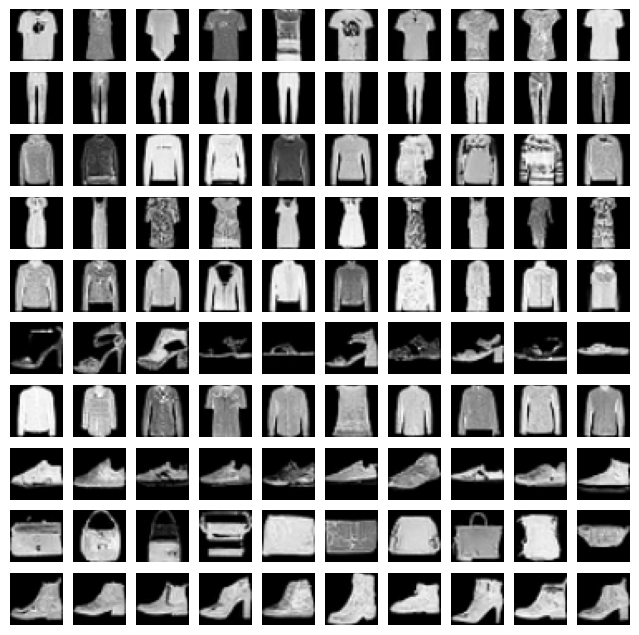

In [22]:
!pip install torchmetrics[image]
!pip install torch-fidelity
import re
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Subset


args = {
    "checkpoint": "Fashion-MNIST_unet_dim=32_beta=linear_loss=smooth_l1_lr=0.0003_cond=True_bs=32_epoch=105-val_loss=0.00991.ckpt",
    "num_samples": 100,
    "bs": 100,
    "skip_plot": False
}

# Function to parse checkpoint filename
def parse_checkpoint_filename(filename, default_params=None):
    # Default values for missing parameters
    if default_params is None:
        default_params = {
            "dataset_name": "MNIST",
            "unet_dim": 32,
            "beta_schedule": "linear",
            "loss": "smooth_l1",
            "lr": 0.0003,
            "cond": False,
            "bs": 32,
            "epoch": 0,
            "val_loss": None
        }

    # Extract the base filename
    base_filename = filename.split('/')[-1]

    # Adjusted regex pattern to allow optional parameters
    pattern = (
        r"^(?P<dataset_name>[\w\-]+)_unet_dim=(?P<unet_dim>\d+)_beta=(?P<beta_schedule>\w+)"
        r"(?:_loss=(?P<loss>[a-zA-Z0-9_]+))?"
        r"(?:_lr=(?P<lr>[0-9.e-]+))?"
        r"(?:_cond=(?P<cond>\w+))?"
        r"(?:_bs=(?P<bs>\d+))?"
        r"_epoch=(?P<epoch>\d+)-val_loss=(?P<val_loss>\d+\.\d+)\.ckpt$"
    )

    # Match the filename against the pattern
    match = re.match(pattern, base_filename)
    if not match:
        raise ValueError(f"Invalid checkpoint filename format: {base_filename}")

    # Extract parameters
    params = match.groupdict()

    # Convert extracted parameters and set defaults for missing ones
    params = {**default_params, **{k: v for k, v in params.items() if v is not None}}
    params['unet_dim'] = int(params['unet_dim'])
    params['lr'] = float(params['lr']) if params['lr'] is not None else default_params['lr']
    params['cond'] = params['cond'].lower() == 'true' if isinstance(params['cond'], str) else default_params['cond']
    params['bs'] = int(params['bs']) if params['bs'] is not None else default_params['bs']
    params['epoch'] = int(params['epoch'])
    params['val_loss'] = float(params['val_loss']) if params['val_loss'] is not None else default_params['val_loss']

    return params


# Logging configuration
logging.basicConfig(level=logging.INFO,
                    format=('%(filename)s: '
                            '%(levelname)s: '
                            '%(funcName)s(): '
                            '%(lineno)d:\t'
                            '%(message)s'))

logger = logging.getLogger(__name__)

# Set device to cuda if available, set to mps if available else cpu
device = get_device(torch)
logger.info(f"Using device: {device}")

# Extract parameters from the checkpoint filename
try:
    checkpoint_params = parse_checkpoint_filename(args['checkpoint'])
    logger.info(f"Extracted parameters from checkpoint: {checkpoint_params}")
except ValueError as e:
    logger.error(e)
    exit(1)

# Initialize the model using extracted parameters
num_channels = 3 if checkpoint_params['dataset_name'] == 'CIFAR10' else 1

if checkpoint_params['dataset_name'] == 'CIFAR10' and checkpoint_params['unet_dim'] == 128:
    dim_mults = (1,2,2,2)
    resnet_block_groups = 2
    dropout = 0.1
    horizontal_flips = True
    dim_att_head = 16
else:
    dim_mults = (1,2,4,8)
    resnet_block_groups = 4
    dropout = 0.0
    horizontal_flips = False
    dim_att_head = 32

model = DdpmNet(
    unet_dim=checkpoint_params['unet_dim'],
    channels=num_channels,
    img_size=32,
    beta_schedule=checkpoint_params['beta_schedule'],
    loss_type=checkpoint_params['loss'],
    lr=checkpoint_params['lr'],
    cond=checkpoint_params['cond'],
    dim_mults=dim_mults,
    resnet_block_groups=resnet_block_groups,
    dropout=dropout,
    horizontal_flips=horizontal_flips,
    dim_att_head=dim_att_head
)

ddpm_light = DdpmLight.load_from_checkpoint(args['checkpoint'], ddpmnet=model)
ddpm_light.eval().to(device)

# Generate samples
sample_size = args['num_samples']
batch_size = min(args['bs'], sample_size)
columnrow = batch_size // 10

# Generate class labels for conditional sampling
klass = torch.cat([torch.full((columnrow,), i) for i in range(10)])
klass = klass.to(device)

with torch.no_grad():
    for i in tqdm(range(sample_size // batch_size), desc="Generating Samples"):
        generated_samples = ddpm_light.sample(batch_size, klass).view(batch_size, num_channels, 32, 32).to(device)

        # Normalize generated samples to [0, 1]
        generated_samples = ((generated_samples + 1) / 2).clamp(0, 1)
        if num_channels == 1:
            generated_samples = generated_samples.repeat(1, 3, 1, 1)  # Convert to RGB

# Visualize generated samples
if args['skip_plot'] is False:
    logger.info("Saving generated samples...")
    fig = plt.figure(figsize=(8, 8))
    columns = 10
    rows = sample_size // 10
    for i in range(1, columns * rows + 1):
        img = generated_samples[i - 1].cpu().detach().numpy().transpose(1, 2, 0).squeeze()
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        if num_channels == 1:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img)

## FID Score
Frèchet Inception Distance (FID) metric to see the quality of the generated samples.  FID
measures the similarity between real and generated images by comparing their feature distributions, extracted using an Inception V3 network. Lower FID scores indicate higher similarity, reflecting better image quality and diversity.

It is defined as:
$$FID = \left\|\mu_r - \mu_g\right\|_2^2 + \text{Tr}\left(\Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g}\right)$$


In [23]:
!pip install torchmetrics[image]
!pip install torch-fidelity
import re
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Subset


args = {
    "checkpoint": "Fashion-MNIST_unet_dim=32_beta=linear_loss=smooth_l1_lr=0.0003_cond=True_bs=32_epoch=105-val_loss=0.00991.ckpt",
    "num_samples": 10000,
    "bs": 100
}

# Function to parse checkpoint filename
def parse_checkpoint_filename(filename, default_params=None):
    # Default values for missing parameters
    if default_params is None:
        default_params = {
            "dataset_name": "MNIST",
            "unet_dim": 32,
            "beta_schedule": "linear",
            "loss": "smooth_l1",
            "lr": 0.0003,
            "cond": False,
            "bs": 32,
            "epoch": 0,
            "val_loss": None
        }

    # Extract the base filename
    base_filename = filename.split('/')[-1]

    # Adjusted regex pattern to allow optional parameters
    pattern = (
        r"^(?P<dataset_name>[\w\-]+)_unet_dim=(?P<unet_dim>\d+)_beta=(?P<beta_schedule>\w+)"
        r"(?:_loss=(?P<loss>[a-zA-Z0-9_]+))?"
        r"(?:_lr=(?P<lr>[0-9.e-]+))?"
        r"(?:_cond=(?P<cond>\w+))?"
        r"(?:_bs=(?P<bs>\d+))?"
        r"_epoch=(?P<epoch>\d+)-val_loss=(?P<val_loss>\d+\.\d+)\.ckpt$"
    )

    # Match the filename against the pattern
    match = re.match(pattern, base_filename)
    if not match:
        raise ValueError(f"Invalid checkpoint filename format: {base_filename}")

    # Extract parameters
    params = match.groupdict()

    # Convert extracted parameters and set defaults for missing ones
    params = {**default_params, **{k: v for k, v in params.items() if v is not None}}
    params['unet_dim'] = int(params['unet_dim'])
    params['lr'] = float(params['lr']) if params['lr'] is not None else default_params['lr']
    params['cond'] = params['cond'].lower() == 'true' if isinstance(params['cond'], str) else default_params['cond']
    params['bs'] = int(params['bs']) if params['bs'] is not None else default_params['bs']
    params['epoch'] = int(params['epoch'])
    params['val_loss'] = float(params['val_loss']) if params['val_loss'] is not None else default_params['val_loss']

    return params


# Logging configuration
logging.basicConfig(level=logging.INFO,
                    format=('%(filename)s: '
                            '%(levelname)s: '
                            '%(funcName)s(): '
                            '%(lineno)d:\t'
                            '%(message)s'))

logger = logging.getLogger(__name__)

# Set device to cuda if available, set to mps if available else cpu
device = get_device(torch)
logger.info(f"Using device: {device}")

# Extract parameters from the checkpoint filename
try:
    checkpoint_params = parse_checkpoint_filename(args['checkpoint'])
    logger.info(f"Extracted parameters from checkpoint: {checkpoint_params}")
except ValueError as e:
    logger.error(e)
    exit(1)

# Initialize the model using extracted parameters
num_channels = 3 if checkpoint_params['dataset_name'] == 'CIFAR10' else 1

if checkpoint_params['dataset_name'] == 'CIFAR10' and checkpoint_params['unet_dim'] == 128:
    dim_mults = (1,2,2,2)
    resnet_block_groups = 2
    dropout = 0.1
    horizontal_flips = True
    dim_att_head = 16
else:
    dim_mults = (1,2,4,8)
    resnet_block_groups = 4
    dropout = 0.0
    horizontal_flips = False
    dim_att_head = 32

model = DdpmNet(
    unet_dim=checkpoint_params['unet_dim'],
    channels=num_channels,
    img_size=32,
    beta_schedule=checkpoint_params['beta_schedule'],
    loss_type=checkpoint_params['loss'],
    lr=checkpoint_params['lr'],
    cond=checkpoint_params['cond'],
    dim_mults=dim_mults,
    resnet_block_groups=resnet_block_groups,
    dropout=dropout,
    horizontal_flips=horizontal_flips,
    dim_att_head=dim_att_head
)

ddpm_light = DdpmLight.load_from_checkpoint(args['checkpoint'], ddpmnet=model)
ddpm_light.eval().to(device)

# Generate samples
sample_size = args['num_samples']
batch_size = min(args['bs'], sample_size)
columnrow = batch_size // 10

# Generate class labels for conditional sampling
klass = torch.cat([torch.full((columnrow,), i) for i in range(10)])
klass = klass.to(device)

# Initialize FID metric
fid = FrechetInceptionDistance(feature=2048, normalize=True, reset_real_features=False, input_img_size=(3,32,32)).to(device)
fid.set_dtype(torch.float64)

# Add real images to FID computation
train_dataset, _, _ = get_dataset(checkpoint_params['dataset_name'])
subset_indices = list(range(sample_size))  # Indices for the subset
subset_dataset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(subset_dataset, batch_size=checkpoint_params['bs'], shuffle=False)
for real_batch in tqdm(train_dataloader, desc="Adding real images to FID computation"):
    real_images, _ = real_batch
    # Normalize real images to [0, 1]
    real_images = ((real_images + 1) / 2).clamp(0, 1).to(device)
    if num_channels == 1:
        real_images = real_images.repeat(1, 3, 1, 1)  # Convert to RGB
    # Move real images to CPU
    real_images = real_images.to(dtype=torch.float64)
    fid.update(real_images, real=True)

with torch.no_grad():
    for i in tqdm(range(sample_size // batch_size), desc="Generating Samples"):
        generated_samples = ddpm_light.sample(batch_size, klass).view(batch_size, num_channels, 32, 32).to(device)

        # Normalize generated samples to [0, 1]
        generated_samples = ((generated_samples + 1) / 2).clamp(0, 1)
        if num_channels == 1:
            generated_samples = generated_samples.repeat(1, 3, 1, 1)  # Convert to RGB

        # Add generated images to FID
        logger.info("Adding generated images to FID computation...")
        generated_samples = generated_samples.to(dtype=torch.float64)
        fid.update(generated_samples, real=False)

# Compute FID score
fid_score = fid.compute()
print(f"FID Score: {fid_score}")


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


1305753438.py: INFO: <module>(): 77:	Using device: cuda
1305753438.py: INFO: <module>(): 82:	Extracted parameters from checkpoint: {'dataset_name': 'Fashion-MNIST', 'unet_dim': 32, 'beta_schedule': 'linear', 'loss': 'smooth_l1', 'lr': 0.0003, 'cond': True, 'bs': 32, 'epoch': 105, 'val_loss': 0.00991}

Adding real images to FID computation: 100%|██████████| 313/313 [10:46<00:00,  2.07s/it]

Generating Samples:   0%|          | 0/100 [00:00<?, ?it/s]1305753438.py: INFO: <module>(): 159:	Adding generated images to FID computation...

Generating Samples:   1%|          | 1/100 [00:37<1:01:56, 37.54s/it]1305753438.py: INFO: <module>(): 159:	Adding generated images to FID computation...

Generating Samples:   2%|▏         | 2/100 [01:20<1:06:23, 40.64s/it]1305753438.py: INFO: <module>(): 159:	Adding generated images to FID computation...

Generating Samples:   3%|▎         | 3/100 [02:03<1:07:19, 41.65s/it]1305753438.py: INFO: <module>(): 159:	Adding generated images to FID computation...

G

FID Score: 12.284158269140221
